# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">Jan Aguiló Plana</font>

E-mail: <font color="blue">jan.aguilo01@estudiant.upf.edu</font>

Date: <font color="blue">08/10/2024</font>

In [77]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import datetime

In [78]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "data/covid-lockdown-catalonia/CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development, and answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1001

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 1001 documents


# 1. Auxiliary functions

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [79]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    inter = set1.intersection(set2)
    union = set1.union(set2)
    if len(union) == 0:
        return 0.0
    jacc = len(inter)/len(union)
    return jacc

<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [80]:
a1 = ['Hello', 'Bye', 'Jan']
a2 = ['Hello', 'Bye', 'Pol']
a3 = ['Hello', 'Bye', 'Jan', 'Aniol']
a4 = []
a5 = []
a6 = ['Hello', 'Bye', 'Jan']
print(jaccard_similarity(a1,a2))
print(jaccard_similarity(a1,a3))
print(jaccard_similarity(a4,a5))
print(jaccard_similarity(a1,a6))

0.5
0.75
0.0
1.0


<font size="+1" color="red">Replace this cell with your code for function "clean"</font>

In [81]:
def clean(text):
    # 1
    text = re.sub('RT','', text)
    
    #2
    text = text.lower()
    
    #3
    text = re.sub('ñ', 'n', text)
    text = re.sub('Ñ', 'n', text)
    text = re.sub('ó', 'o', text)
    text = re.sub('ò', 'o', text)
    text = re.sub('à', 'a', text)
    text = re.sub('á', 'a', text)
    text = re.sub('ú', 'u', text)
    text = re.sub('l·l', 'll', text)
    
    #4
    text = re.sub(r'http\S+|https\S+', '', text)

    #5
    text = text.strip()
    
    #6
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    #7
    text = re.sub(r'\s+', ' ', text)

    return text

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font>

In [82]:
test_texts = ["RT This is a test tweet! Check https://test-url.com",  
    "¡Hola, cómo estás! Visit http://website.com",  
    "RT: Привет! Как дела? http://russian-site.com",  
    "Ñandú l·l jumping over á rocks.", 
    "Test   with    multiple     spaces!"]

cleaned_texts = [clean(text) for text in test_texts]
for i, cleaned in enumerate(cleaned_texts, 1):
    print(f"Original: {test_texts[i-1]}")
    print(f"Cleaned: {cleaned}\n")

Original: RT This is a test tweet! Check https://test-url.com
Cleaned: this is a test tweet check

Original: ¡Hola, cómo estás! Visit http://website.com
Cleaned: hola como estas visit

Original: RT: Привет! Как дела? http://russian-site.com
Cleaned:  

Original: Ñandú l·l jumping over á rocks.
Cleaned: nandu ll jumping over a rocks

Original: Test   with    multiple     spaces!
Cleaned: test with multiple spaces



# 2. Implement an n-gram extractor

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [83]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    
    # We first iterate through the tokens and remove the ones that doesn't satisfy the minimum length of characters
    filtered = []
    for token in tokens:
        if len(token) >= MIN_TOKEN_LENGTH:
            filtered.append(token)
    
    # We iterate through the length of the tokens list (but substracting size + 1 elements so that the bounds match)
    for i in range(len(filtered) - size + 1):
        
        # We create a current array to store each of the corresponding tokens
        current = []
        
        # For each index, we iterate through the "size" elements (3 in this case) of its right and add them to the current array
        for elem in range(i, size + i):
            current.append(filtered[elem])
        current = ' '.join(current)
        ngrams.append(current)

    
    return ngrams


<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [84]:
print(messages[990])
print(ngrams(messages[990], 3))

Clam per la suspensió dels desnonaments en plena crisi pel coronavirus https://t.co/0g1AtSELwl
['clam per suspensio', 'per suspensio dels', 'suspensio dels desnonaments', 'dels desnonaments plena', 'desnonaments plena crisi', 'plena crisi pel', 'crisi pel coronavirus']


# 3. Estimation of brute force all-pairs method

In [85]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

<font size="+1" color="red">Replace this cell with your code for generating the requested plot. Remember to add a title and label for the x and y axis.</font>

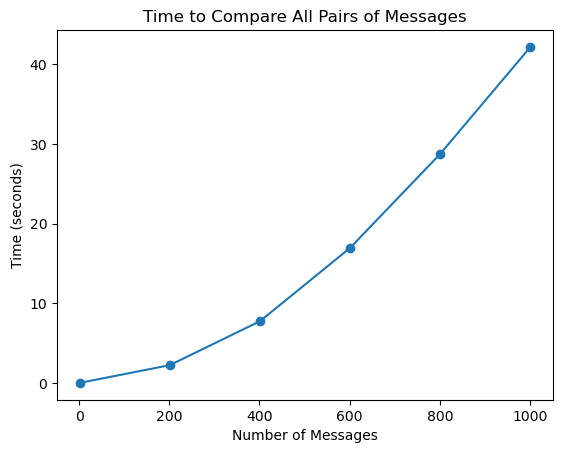

In [86]:
x_values = range(1, 1002, 200)

times = []
size = 5

for limit in x_values:
    elapsed_time = time_brute_force_similarities(messages, limit, size)
    times.append(elapsed_time)

plt.plot(x_values, times, marker='o')
plt.title('Time to Compare All Pairs of Messages')
plt.xlabel('Number of Messages')
plt.ylabel('Time (seconds)')
plt.show()

<font size="+1" color="red">Replace this cell with (1) a brief commmentary about what you see in this plot, and (2) your estimate for how long it would take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds. Justify precisely your calculations.</font>

(1) We observe that the time it takes to compute brute-force similarities increases non-linearly as the number of messages increases. This is expected, as the brute force method involves comparing every pair of messages, which leads to a quadratic growth in the number of comparisons. This is expected because the number of comparisons is proportional to n(n-1)/2 (all the comparisons), where n is the number of messages.

(2) Let's take for instance the time it takes to run for 1000 messages, which is 40 approximately (let's denote it T(1000) = 40s). Then we calculate the number of comparisons for 1000 messages which will be from the formula in (1) and denote it N(1000) = 1000*999/2 = 499500. Now we divide T(1000) by N(1000) to know the average time it takes for 1 comparison: T(1) = 40/499500 = 0.00008008. Now we multiply it by the number of comparisons that it would take for the entire matrix (assuming we have 35500 messages): T(1) * N(35500) = 0.00008008* 35500*35499/2 = 50459s. That is, 14 hours, 0 minutes, and 59 seconds.

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index dictionary.</font>

In [87]:
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        
        # If the ngram is not in the dictionary, we upload it 
        if ngram not in ngram_to_index:
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1

num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 8014 distinct ngrams in the 1001 documents


<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [88]:
strings = ["els restaurants han reduir", "supera fins tot mateix"]

for string in strings:
    all_ngrams = ngrams(string, NGRAM_SIZE)
    
    for ngram in all_ngrams:
        if ngram in ngram_to_index:
            
            index = ngram_to_index[ngram]
            print(f"Ngram: '{ngram}' -> Index: {index}")
            
            retrieved_ngram = index_to_ngram[index]
            print(f"Index: {index} -> Retrieved Ngram: '{retrieved_ngram}'")
            
        else:
            print(f"Ngram: '{ngram}' not found in the dictionary.")

Ngram: 'els restaurants han reduir' -> Index: 14
Index: 14 -> Retrieved Ngram: 'els restaurants han reduir'
Ngram: 'supera fins tot mateix' -> Index: 36
Index: 36 -> Retrieved Ngram: 'supera fins tot mateix'


## 2.2 Create table ngrams x documents

In [89]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 8014 rows (distinct shingles) x 1001 columns (distinct documents)


<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [90]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        
        # Check if the ngram is already in the dictionary
        if ngram in ngram_to_index:
            
            #Take the row of the corresponding ngram
            row = ngram_to_index[ngram]
            M_ngram_doc[row][docid] = True
        else:
            M_ngram_doc[row][docid] = False

<font size="+1" color="red">Replace this cell with your code for printing the density of the M_ngram_doc matrix as a percentage. Use 4 decimals.</font>

In [91]:
non_zero = np.count_nonzero(M_ngram_doc)
num_cells = M_ngram_doc.size
percentage = (non_zero/num_cells)*100
print(f'The density of the M_ngram_doc matrix is: {round(percentage, 4)} %')

The density of the M_ngram_doc matrix is: 0.1393 %


<font size="+1" color="red">Replace this cell with your code for printing rows 9602 and 941 of the M_ngram_doc matrix.</font>

In [92]:
def print_non_zero_positions(docid):
    
    message = messages[docid]
    cleaned_message = clean(message)
    
    # We find using the nonzero function the number of 0
    non_zero_rows = np.nonzero(M_ngram_doc[:, docid])[0]
    
    print(f"Positions of non-zeros in column of docid {docid} of M_ngram_doc\n")
    print(f"Clean message:\n{cleaned_message}\n")
    print("Non-zeros in corresponding rows:")
    
    non_zero_ngrams = [f"{row} ({index_to_ngram[row]})" for row in non_zero_rows]
    print(non_zero_ngrams)

# We try with 941 and 16 (the example) because 9602 doesn't exist
print_non_zero_positions(941)
print_non_zero_positions(16)

Positions of non-zeros in column of docid 941 of M_ngram_doc

Clean message:
hospiolot usem de forma responsable els recursos sanitaris 061 urgncies per coronavirus i sanitaries 012 consultes general

Non-zeros in corresponding rows:
['1052 (usem forma responsable els)', '1053 (forma responsable els recursos)', '1054 (responsable els recursos sanitaris)', '1055 (els recursos sanitaris 061)', '1056 (recursos sanitaris 061 urgncies)', '1057 (sanitaris 061 urgncies per)', '1058 (061 urgncies per coronavirus)', '1059 (urgncies per coronavirus sanitaries)', '1060 (per coronavirus sanitaries 012)', '1061 (coronavirus sanitaries 012 consultes)', '7735 (hospiolot usem forma responsable)', '7736 (sanitaries 012 consultes general)']
Positions of non-zeros in column of docid 16 of M_ngram_doc

Clean message:
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplaaments de cap de setmana tot el que sigui ma

Non-zeros in corresponding rows:
['175 (emergenciescat demana 

# 3. Implement a permutation generator

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [93]:
def random_permutation(k):
    # We create a list of integers from 0 to k-1
    array = list(range(k))

    # We generate a random permutation of the array using the function shuffle
    random.shuffle(array)
    
    return array
print(random_permutation(20))    

[5, 6, 4, 19, 10, 9, 14, 2, 15, 12, 18, 17, 13, 1, 0, 8, 3, 11, 7, 16]


In [94]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['5 (test5)', '3 (test3)', '4 (test4)', '2 (test2)', '1 (test1)']
['5 (epsilon)', '3 (beta)', '4 (delta)', '2 (gamma)', '1 (alpha)']

Test another permutation
['4 (test4)', '2 (test2)', '1 (test1)', '5 (test5)', '3 (test3)']
['4 (delta)', '2 (gamma)', '1 (alpha)', '5 (epsilon)', '3 (beta)']


# 4. Compute the signature of each document

In [95]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 4901, 7674, 742, 4867, ...
Permutation 1: 6171, 4550, 5862, 947, ...
Permutation 2: 6370, 7595, 1900, 6675, ...
Permutation 3: 7346, 4282, 6615, 3138, ...
Permutation 4: 2932, 7505, 6602, 1673, ...


In [96]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [97]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        
        # We compute the first ngram using the function above
        first_ngram = find_first_one(docid, permutation)
        
        # Store the result in the signature matrix
        M_signature_doc[permutation_num, docid] = first_ngram

Creating signatures for permutation 1/5
- Scanning document 0 of 1001
- Scanning document 1000 of 1001
Creating signatures for permutation 2/5
- Scanning document 0 of 1001
- Scanning document 1000 of 1001
Creating signatures for permutation 3/5
- Scanning document 0 of 1001
- Scanning document 1000 of 1001
Creating signatures for permutation 4/5
- Scanning document 0 of 1001
- Scanning document 1000 of 1001
Creating signatures for permutation 5/5
- Scanning document 0 of 1001
- Scanning document 1000 of 1001


In [98]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 21 )
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 24 )

Document #21
Message       : El problema és económic... ja no és només que primi lo económic a lo personal, és que fins i tot en això el @govern s'equivoca, doncs al final la factura que s'haurà de pagar serà més gran.... ja és més gran del que hauria sigut de fer les coses bé i a temps. https://t.co/jFXHAMZHO0
Clean message : el problema s economic ja no s noms que primi lo economic a lo personal s que fins i tot en aixo el govern sequivoca doncs al final la factura que shaura de pagar sera ms gran ja s ms gran del que hauria sigut de fer les coses b i a temps
Ngrams        : [228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254]
Signature     : [244.0, 233.0, 230.0, 232.0, 248.0]

Document #24
Message       : RT @QuimTorraiPla: Seguiu les recomanacions: eviteu qualsevol desplaçament al màxim
Clean message : quimtorraipla seguiu les recomanacions eviteu qualsevol desplaament al maxim
Ngrams        : [274,

# 5. Compare all pairs of signatures

<font size="+1" color="red">Replace this cell with your code for comparing all signatures; print all documents that have at least X signature matches, considering both full matches and partial matches. X should be 0.5% of the  number of documents.</font>

In [99]:
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # We compute the similarity with the function from the beginning
                similarity = jaccard_similarity(signature1, signature2)
                
                # Increase count_sig_full_matches and count_sig_partial_matches as needed
                # Include docid2 in is_possible_duplicate if needed
                if similarity == 1.0:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = True
                
                elif (0.2 < similarity < 1.0):
                    count_sig_partial_matches += 1
                    is_possible_duplicate[docid2] = True
                    
                
        # 0.5% of the number of documents
        threshold = int(0.005 * len(messages)) 
        
        # If the number of partial matches plus full matches exceeds a threshold
        #  print the document doc1 and indicate how many matches of each type it has
        if count_sig_full_matches + count_sig_partial_matches > threshold:
            print("Document %d has %d full matches and %d partial matches" % (docid1, count_sig_full_matches, count_sig_partial_matches))

0/1001 documents scanned
Document 16 has 6 full matches and 0 partial matches
Document 22 has 7 full matches and 0 partial matches
Document 32 has 5 full matches and 5 partial matches
Document 42 has 2 full matches and 6 partial matches
Document 83 has 16 full matches and 0 partial matches
Document 95 has 9 full matches and 0 partial matches
Document 104 has 7 full matches and 0 partial matches
Document 166 has 13 full matches and 0 partial matches
Document 175 has 6 full matches and 0 partial matches
Document 249 has 8 full matches and 0 partial matches
Document 328 has 7 full matches and 0 partial matches
Document 385 has 7 full matches and 2 partial matches
500/1001 documents scanned
1000/1001 documents scanned


<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

Original text: RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…

This tweet gets retweeted without any changes because it’s an official message from a trusted source about public safety. People are less likely to modify it since it's important to keep the warning clear and urgent, and any edits might reduce its impact.

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

Original text: RT @emergenciescat: El comitè tècnic del Pla #PROCICAT  per evitar la propagació del #coronavirus ha proposat al Govern que ordeni el cessa…

This tweet shows more partial matches because people might add their own thoughts or slightly edit it. The main message stays the same, but users are likely adjusting it to fit their personal style or make it shorter for easier reading.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>